In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.build import bulk
from abtem.plot import show_atoms
import numpy as np
import cupy as cp
from abtem.temperature import FrozenPhonons
import matplotlib.pyplot as plt

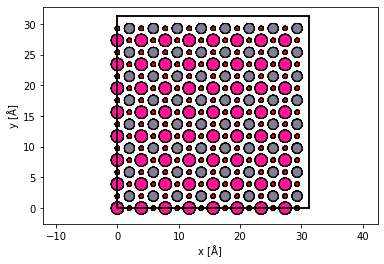

In [65]:
#atoms = bulk('Au', 'fcc', a=4.06, cubic=True)
from ase.io import read
atoms = read('srtio3.cif')

#atoms.numbers[atoms.numbers == 38] = 38
#atoms.numbers[atoms.numbers == 22] = 38
#atoms.numbers[atoms.numbers == 8] = 38

atoms *= (8,8,51)
show_atoms(atoms)

In [70]:
len(atoms)

16320

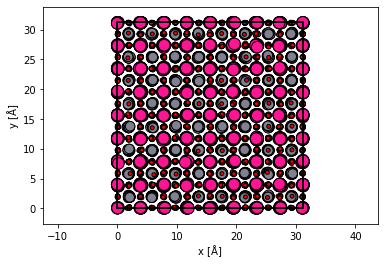

In [66]:
fp = FrozenPhonons(atoms, 10, {'Sr':.1,'Ti':.1,'O':.1}, seed=7)

atoms_conf = next(fp.generate_atoms())
show_atoms(atoms_conf)

In [71]:
from abtem.potentials import Potential

#potential = Potential(fp, sampling=.008)


In [72]:
potential = Potential(fp, sampling=.008)
potential.grid.snap_to_power(2)
#g = potential.generate_tds_potentials()

In [8]:
potential.gpts

(4096, 4096)

The ETA after the first TDS configuration is overestimated by an order of magnitude, since the cache of potential integrals is getting filled.

In [73]:
from abtem.waves import PlaneWave

wave = PlaneWave(energy=300e3, device='cpu')

exit_wave = wave.multislice(potential)

KeyboardInterrupt: 

In [49]:
patterns = exit_wave.diffraction_pattern()
#exit_wave.array.shape
#patterns.array

(<matplotlib.axes._subplots.AxesSubplot at 0x1abc1c4ec88>,
 <matplotlib.image.AxesImage at 0x1abc4169888>)

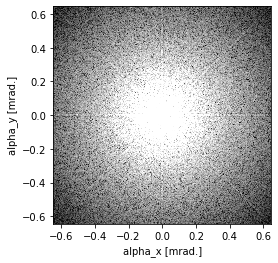

In [50]:
patterns[0].show(display_func=lambda x: np.log(1 + 1e-2 * x), vmax=10)

(-0.6453261405657214,
 0.6453261405657214,
 -0.6453261405657214,
 0.6453261405657214)

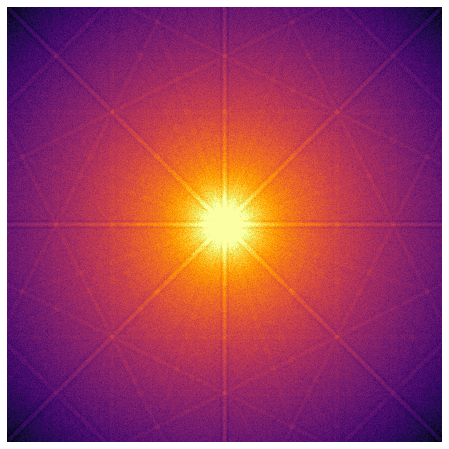

In [58]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
patterns.mean(0).show(display_func=lambda x: np.log(1 + 1e-2 * x), vmax=15, cmap='inferno', ax=ax)

ax.axis('off')

#ax.set_xlim([-.15,.15])
#ax.set_ylim([-.15,.15])

## STEM with TDS

Calculating (4D)-STEM with TDS is no different than without, the only exception is that the potential can no longer be calculated explicitly beforehand. You have to pay attention to the `storage` argument of the potential, which determines where the precalculated potential is stored. The options are

* `device` : (default) The potential is stored on the GPU
* `host` : The potential is in the host memory and individual slices are transferred to the GPU
* `disk` : The potential is saved to disk and read back in chunks

The distinction between `device` and `host` only matters, if you are doing GPU calculations. `device` is always the preferred option, but may not be possible due to memory constraints. Choosing disk should only be done as a workaround, for systems with very low memory.

In [62]:
%load_ext autoreload
%autoreload 2

from ase.io import read
from abtem.scan import LineScan
from abtem.detect import AnnularDetector
from abtem.waves import Probe
from abtem.measure import Measurement
from abtem.potentials import Potential
from abtem.temperature import TDS

atoms = read('graphene.cif') * (3, 2, 1)
atoms.center(vacuum=3,axis=2)

potential = Potential(TDS(atoms, 20, {'C':.2}, seed=7), sampling=.02)

linescan = LineScan(start=[4.06, 0], end=[4.06, 4.06], gpts=100)

probe = Probe(energy=300e3, semiangle_cutoff=.03, focal_spread=60, defocus=50, device='gpu')
haadf = AnnularDetector(inner=.09, outer=.2)

#potential.show(scans=linescan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
measurements = probe.scan(linescan, [haadf], potential, max_batch=1, pbar=True)

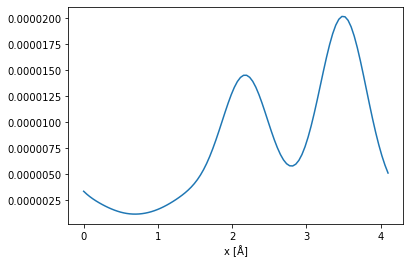

In [20]:
#ax=Measurement.read('linescan.hdf5').show()
measurements[haadf].show()
#print(ax)

In [26]:
from tqdm.notebook import tqdm
import time

pbar1 = tqdm(total=10)
pbar2 = tqdm(total=10)

for i in range(10):
    time.sleep(.1)
    pbar1.update(1)
    for j in range(10):
        time.sleep(.1)
        pbar2.update(1)
    pbar2.reset()
